In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
%cd /content/drive/My Drive/Colab Notebooks/Text_Summarization_Task


/content/drive/My Drive/Colab Notebooks/Text_Summarization_Task


In [7]:
import tensorflow as tf 
tf.test.gpu_device_name() 

'/device:GPU:0'

# **Abstractive Approach using sequence to sequence Model**

This is a very interesting approach. Here, we generate new sentences from the original text. This is in contrast to the extractive approach we saw earlier where we used only the sentences that were present. The sentences generated through abstractive summarization might not be present in the original text.

we are going to build an Abstractive Text Summarizer using Deep Learning in this Notebook.

## **Running preprocessing Notebook to use it's functions**

In [8]:
%run Preprocessing.ipynb


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     |████████████████████████████████| 112kB 39.5MB/s 
  Created wheel for PyArabic: filename=PyArabic-0.6.7-cp36-none-any.whl size=108603 sha256=881f3c399ea26cd49bed378521d8c81a67853d184452955c74e2d600c5dcba07
  Stored in directory: /root/.cache/pip/wheels/c6/50/b1/4df7f705f36e91360ab04416dbf1017084698d30a7a3645b5e
Successfully built PyArabic
     |████████████████████████████████| 245kB 32.2MB/s 
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## **Importing Custom attention layer**
Keras Doesn't support attention layer so I have downloaded custom attention layer from here [github](https://github.com/thushv89/attention_keras/blob/master/layers/attention.py )

In [0]:
from attention import AttentionLayer

## **Import the Libraries**

In [10]:
import numpy as np
import pandas as pd 
import re           
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

Using TensorFlow backend.


## **The Dataset**

The Dataset are reviews of fine foods from amazon.The dataset has up to 500,000 reviews but I have only used 100,000 to decrease training time.  

The dataset can be acquire from here: https://www.kaggle.com/snap/amazon-fine-food-reviews

In [0]:
data=pd.read_csv("/content/drive/My Drive/Colab Notebooks/Text_Summarization_Task/Datasets/amazon-fine-food-reviews.csv",nrows=100000)

### **Drop Duplicates and NA values**

In [0]:
data.drop_duplicates(subset=['Text'],inplace=True)  #dropping duplicates
data.dropna(axis=0,inplace=True)   #dropping na

## **Preprocessing**

We are going to use functions from the proprocessing notebook on the data here.  
For details about the functions check the notebook
but in short we are doing here to text and summary is the following:
*   Convert everything to lowercase
*   Contraction mapping
*   Eliminate punctuations and special characters
*   Remove stopwords


### **Text Cleaning**

In [0]:
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(preprocess(t , stemming = False))

In [14]:
cleaned_text[:10]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story c s lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered good made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal',
 'got wild hair taffy ordered five pound bag taffy enjoyable many flavors watermelon root beer melon peppermint grape etc complaint bit much red black licorice flavored pieces parti

### **Summary cleaning**

In [0]:
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(preprocess(t , stemming = False))

In [16]:
cleaned_summary[:10]

['good quality dog food',
 'advertised',
 'delight says',
 'cough medicine',
 'great taffy',
 'nice taffy',
 'great good expensive brands',
 'wonderful tasty taffy',
 'yay barley',
 'healthy dog food']

### **Changing orignal data**

In [0]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

### **Applying start and End tokens in the summary**

In [18]:
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')
for i in range(5):
    print("Review:",data['cleaned_text'][i])
    print("Summary:",data['cleaned_summary'][i])
    print("\n")

Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: _START_ good quality dog food _END_


Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: _START_ advertised _END_


Review: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story c s lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary: _START_ delight says _END_


Review: looking secret ingredient robitussin believe found got addition root beer extract ordered good made cherry soda flavor medicinal
Summary: _START_ cough medicine _END_


Review: great taffy great price wide assortment yummy taffy delivery quick taffy lover deal


## **Understanding the distribution of the sequences**

We can get plot the length of setences in texts or summary to get an idea about how long most of the data

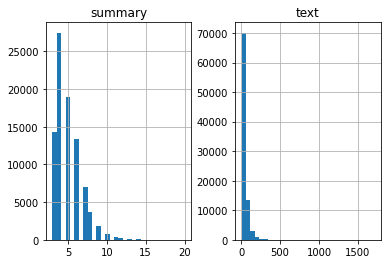

In [19]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

we Can deduce that most of the Summary are less than 10 words and Texts are less than 80.  
We can use this information to fix the maximum size of both.

In [0]:
max_len_text=80 
max_len_summary=10

## **Splitting Dataset**

Now let's split data into training and validations sets. The ratios will be 90% training to 10% validation. this is easily done using sktlearn library 

In [0]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(data['cleaned_text'],data['cleaned_summary'],test_size=0.1,random_state=0,shuffle=True) 

## **Preparing the Tokenizer**

A tokenizer builds the vocabulary and converts a word sequence to an integer sequence.

### **Text Tokenizer**

In [0]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

### **Summary Tokenizer**

In [0]:
#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

## **Model Building**

In [24]:
from tensorflow.keras import backend as K 
K.clear_session() 
latent_dim = 500 

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 500)      25236000    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 80, 500), (N 2002000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [25]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy' , metrics = 'accuracy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=20,callbacks=[es],batch_size=512, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/20
156/156 [==============================] - 187s 1s/step - loss: 2.6720 - accuracy: 0.6593 - val_loss: 2.3364 - val_accuracy: 0.6885
Epoch 2/20
156/156 [==============================] - 188s 1s/step - loss: 2.2967 - accuracy: 0.6896 - val_loss: 2.1806 - val_accuracy: 0.6970
Epoch 3/20
156/156 [==============================] - 188s 1s/step - loss: 2.1523 - accuracy: 0.6962 - val_loss: 2.1012 - val_accuracy: 0.7030
Epoch 4/20
156/156 [==============================] - 188s 1s/step - loss: 2.0373 - accuracy: 0.7024 - val_loss: 2.0576 - val_accuracy: 0.7064
Epoch 5/20
156/156 [==============================] - 189s 1s/step - loss: 1.9422 - accuracy: 0.7076 - val_loss: 2.0430 - val_accuracy: 0.7076
Epoch 6/20
156/156 [==============================] - 188s 1s/step - loss: 1.8616 - accuracy: 0.7124 - val_loss: 2.0056 - val_accuracy: 0.7104
Epoch 7/20
156/156 [==============================] - 188s 1s/step - loss: 1.7819 - accuracy: 0.7170 - val_loss: 1.9690 - val_accuracy: 0.7129

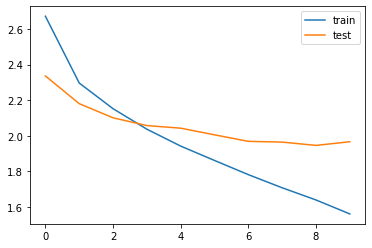

In [26]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend()
pyplot.show()

In [0]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

## **Inference**

In [0]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [0]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [31]:
for i in range(20):
  print("Review:",seq2text(x_val[i]))
  print("Original summary:",seq2summary(y_val[i]))
  print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text)))
  print("\n")

Review: chip flavor comes seeds n t think re salty flavor pretty well balanced thickness crunchiness comparable wheat thin one chip broken half last bag ate br br ingredients list pretty interesting n t long chemical names stone ground yellow corn high oleic sunflower oil brown rice flour flax seeds turbinado cane sugar oat fiber sesame seeds sunflower seeds quinoa soy flour sea salt take look gallery picture back bag br br bag calories contains grams fat make pretty good snack 
Original summary: pretty tasty chips weird ingredients 
Predicted summary:  good


Review: three lb chocolate labs range age years years although give rawhide regularly teeth still funky went first bag chews teeth three dogs improved like much ordered another three bags br br regarding choking hazard dogs need chew need give things dogs attempt swallow pieces large gag dog owner must monitor dog s chewing even dogs gag usually learn first couple times n t gag still need monitor dog re chewing goes anything chew